<h1 align="center"> HR Data for Analytics </h1>

##  Goal

The goal of this project is to find:
- Important factors that caused an employee to leave the company

## About Dataset
This dataset is from Kaggle, the link is [here](https://www.kaggle.com/datasets/jacksonchou/hr-data-for-analytics?datasetId=236694&sortBy=voteCount).
The dataset contains employee profiles of a large company, where each record is an employee.

Attributes in the dataset are:
- ***`satisfaction_level`*** : how much an employee satisfied (0 unsatisfied, 1 satisfied)  
- ***`last_evaluation`*** : an employee's value evaluated by company (0 low , 1 high)
- ***`number_project`*** : number of projects an employee worked on
- ***`average_montly_hours`*** : an employee's average working hours per month
- ***`time_spend_company`*** : years an employee spent in the company
- ***`Work_accident`*** : if an employee had at least one work accident (0 No, 1 Yes)
- ***`left`*** : if an employee left the company (0 No, 1 Yes)
- ***`promotion_last_5years`*** : if an employee had at least one promotion for last five years (0 No, 1 Yes)
- ***`sales`*** : department in which employee works
- ***`salary`*** : an employee's salary level (low, medium, high)

***

<h1 align="center"> 1. Data Cleaning </h1>
<br>
In this part we will:

- rename columns
- check missing values and data type
- check and transform outliers

## 1.1 Import Libraries

In [868]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.cbook import boxplot_stats

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

## 1.2 Import Data

In [413]:
df = pd.read_csv('HR_comma_sep.csv')
df

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,support,low
14995,0.37,0.48,2,160,3,0,1,0,support,low
14996,0.37,0.53,2,143,3,0,1,0,support,low
14997,0.11,0.96,6,280,4,0,1,0,support,low


## 1.3 Rename Columns

To make column names easier to use and understand, we make some change:
- lowercase column names
- *`last_evaluation`* &nbsp;&rarr;&nbsp; *`employee_value`*
- *`average_montly_hours`* &nbsp;&rarr;&nbsp; *`average_monthly_hours`*
- *`time_spend_company`* &nbsp;&rarr;&nbsp; *`year_in_company`*
- *`sales`* &nbsp;&rarr;&nbsp; *`department`*

In [414]:
df.rename(mapper=str.lower, axis='columns', inplace=True)
df.rename(columns={'last_evaluation': 'employee_value',
                   'average_montly_hours': 'average_monthly_hours',
                   'time_spend_company': 'year_in_company', 
                   'sales': 'department'}, inplace=True)
df

,satisfaction_level,employee_value,number_project,average_monthly_hours,year_in_company,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,support,low
14995,0.37,0.48,2,160,3,0,1,0,support,low
14996,0.37,0.53,2,143,3,0,1,0,support,low
14997,0.11,0.96,6,280,4,0,1,0,support,low


## 1.4 Check Missing Values and Datatypes

There are no missing values in the dataset. We also notice that some attributes in int64 or object type (*`work_accident`*, *`promotion_last_5years`*, *`department`*, and *`salary`*) are actually categorical. We will take care of that in modeling section.

In [415]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   employee_value         14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_monthly_hours  14999 non-null  int64  
 4   year_in_company        14999 non-null  int64  
 5   work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


## 1.5 Detect and Handle Outliers

From the *`describe()`*, we see a large difference between the third quartile and the maximum value of *`year_in_company`*, meaning there may be outliers. 

We will find outliers using boxplot and replace these outliers with mean values that group by *`left`* and *`salary`*

In [416]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
satisfaction_level,14999.0,NaN,NaN,NaN,0.612834,0.248631,0.09,0.44,0.64,0.82,1.0
employee_value,14999.0,NaN,NaN,NaN,0.716102,0.171169,0.36,0.56,0.72,0.87,1.0
number_project,14999.0,NaN,NaN,NaN,3.803054,1.232592,2.0,3.0,4.0,5.0,7.0
average_monthly_hours,14999.0,NaN,NaN,NaN,201.050337,49.943099,96.0,156.0,200.0,245.0,310.0
year_in_company,14999.0,NaN,NaN,NaN,3.498233,1.460136,2.0,3.0,3.0,4.0,10.0
work_accident,14999.0,NaN,NaN,NaN,0.14461,0.351719,0.0,0.0,0.0,0.0,1.0
left,14999.0,NaN,NaN,NaN,0.238083,0.425924,0.0,0.0,0.0,0.0,1.0
promotion_last_5years,14999.0,NaN,NaN,NaN,0.021268,0.144281,0.0,0.0,0.0,0.0,1.0
department,14999,10,sales,4140,NaN,NaN,NaN,NaN,NaN,NaN,NaN
salary,14999,3,low,7316,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1.5.1 Plot the Boxplot

We will plot the boxplot of *`satisfaction_level`*, *`employee_value`, `number_project`*, *`average_monthly_hours`*, and *`year_in_company`*.

We set &nbsp; $Q1-3*IQR$ &nbsp; and &nbsp; $Q3+3*IQR$ &nbsp; to be the boundary. Data outside boundaries is considered to be an outlier.

From the plot, we can see that there are outliers in *`year_in_company`*.

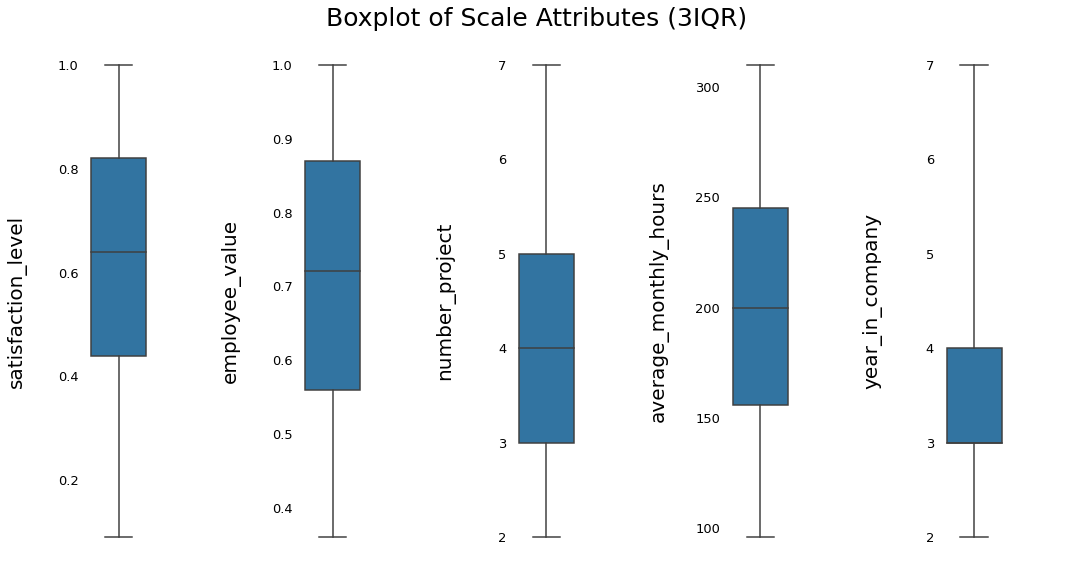

In [820]:
def adjust_boxplot():
    plt.box(False)
    plt.gca().yaxis.label.set_size(20)
    plt.gca().yaxis.labelpad = 0
    plt.tick_params(bottom=False, left=False, labelsize=13, pad=-55)
    plt.tight_layout()
    

plt.figure(figsize=(15,8), constrained_layout=True)
plt.suptitle('Boxplot of Scale Attributes (3IQR)', fontsize=25)

cols = df.columns[:5]

for i in range(len(cols)):
    plt.subplot(1, 5, i+1)
    sns.boxplot(y=df[cols[i]], width=0.3, whis=3)
    adjust_boxplot()

### 1.5.2 Transform Outliers

We replace outliers with mean values for different groups (we select *`left`* and *`salary`*).

Plot the countplot before and after transformation to make sure outliers are properly handled.

In [418]:
# get the upper whisker value of the boxplot
up_whis = boxplot_stats(df['year_in_company'], whis=3)[0]['whishi']
print(f'The upper whisker value is {up_whis}, which means people stay more than {up_whis} years are considered outliers\n')

# replace outliers with mean values that group by 'left' and 'salary'  
outlier_tr = lambda x: np.where(x > up_whis, round(x.mean()), x)
df_origin = df.copy()
df['year_in_company'] = df.groupby(['left', 'salary'])['year_in_company'].transform(outlier_tr)

# show mean values for different groups
print(f'The mean value for different groups')
df.groupby(['left', 'salary'])[['year_in_company']].apply(lambda x: round(x.mean()))

The upper whisker value is 7, which means people stay more than 7 years are considered outliers

The mean value for different groups


year_in_company
left salary                 
0    high                3.0
     low                 3.0
     medium              3.0
1    high                4.0
     low                 4.0
     medium              4.0

In [491]:
def show_count_percentage(fig): 
    """
    Show the count / len(df) in percentage at the position of y / 2 
    
    Parameters
    ----------
    fig : matplotlib.axes._subplots.AxesSubplot
        The matplotlib plot
    """
    
    total = float(len(df))
    for p in fig.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2
        y = p.get_height() * 0.45
        fig.annotate(percentage, (x, y), ha='center', color='black', size=15)
        

def adjust_barplot(fig, title='', rotate=0):    
    """
    Adjust attributes of the barplot 
    
    Parameters
    ----------
    fig : matplotlib.axes._subplots.AxesSubplot
        The matplotlib plot
    title : str, optional
        The title of the subplot (defalut is '')
    rotate: float, optional
        The angle of x tick labels (default is 0)
    """
    
    if not title:
        fig.xaxis.label.set_size(20)
        fig.xaxis.labelpad = 20
        fig.set_ylabel('')
    else:
        fig.set_title(title, size=25, pad=50)
        fig.set_xlabel('')
        fig.set_ylabel('Employee Count', size=15, labelpad=25)
        
    fig.set_frame_on(False)
    fig.tick_params(labelleft=False, left=False, bottom=False, labelsize=15, labelrotation=rotate)
    fig.bar_label(fig.containers[0], padding=10, size=14)
    # add count percentage at the center of bars
    show_count_percentage(fig)

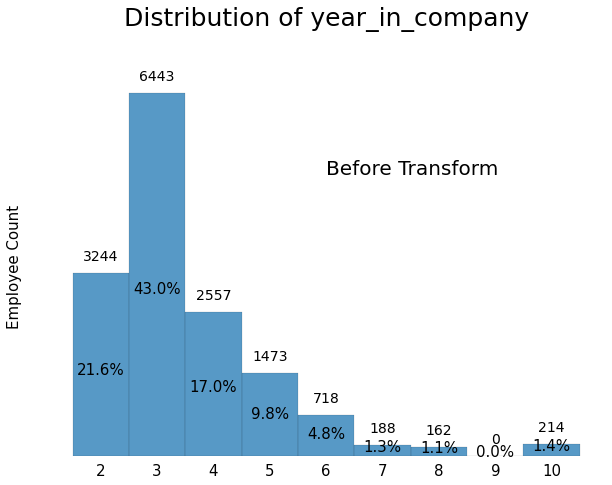

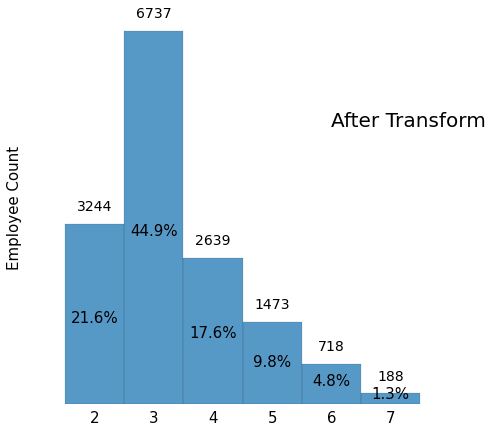

In [684]:
plt.figure(figsize=(10,7))
fig = sns.histplot(df_origin['year_in_company'], linewidth=0.1, discrete=True)
adjust_barplot(fig, title='Distribution of year_in_company')
fig.annotate('Before Transform', (6,5000), size=20)
fig.set_xticks(range(2,11))

plt.figure(figsize=(7,7.2))
fig = sns.histplot(df['year_in_company'], linewidth=0.1, discrete=True)
adjust_barplot(fig, title='Distribution of year_in_company')
fig.set_title('')
fig.annotate('After Transform', (6,5000), size=20)
plt.show()

***

<h1 align='center'> 2. Exploratory Data Analysis </h1>

In this part, we first plot the distribution of all attributes and the correlation between them.

Next, we will analyze people who left the company and try to find their charateristics.

Finally, we will focus on high-value employees (*`employee_value >= 0.75`*) who left the company and try to find why they left.

## 2.1 Dsitribution of Attributes

Plot histograms for scale attributes and barplots for categorical attributes

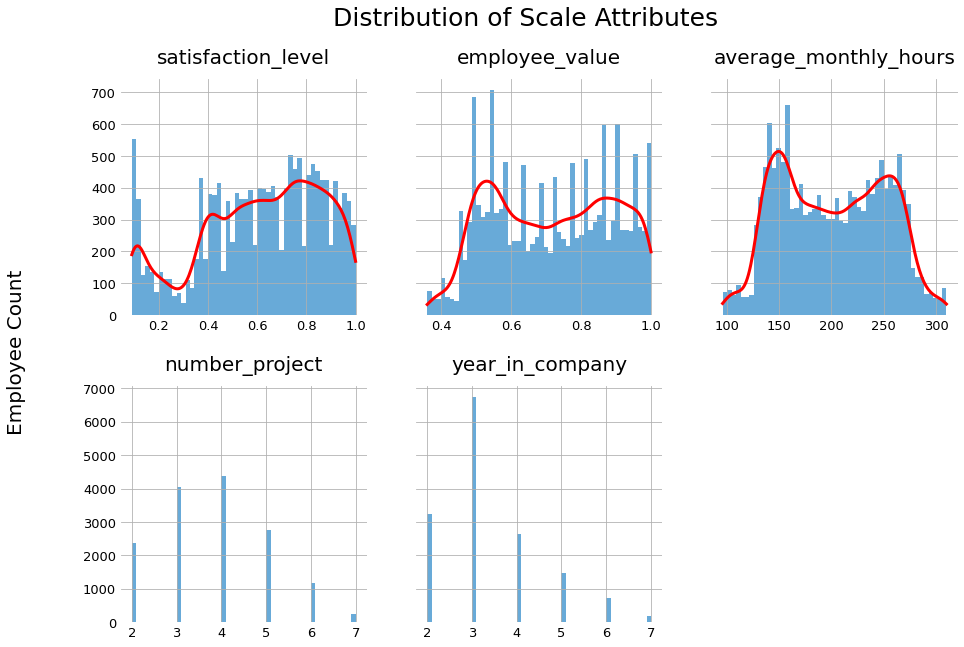

In [821]:
def adjust_histplot(ax):
    ax.lines[0].set_color('red')
    ax.set_frame_on(False)
    ax.grid('on')
    ax.xaxis.set_label_position("top") 
    ax.xaxis.label.set_size(20)
    ax.xaxis.labelpad = 15
    ax.set_ylabel('')
    ax.tick_params(bottom=False, left=False, labelsize=13, pad=1)

cols = [['satisfaction_level', 'employee_value', 'average_monthly_hours'],
        ['number_project', 'year_in_company', None]]

fig, axs = plt.subplots(2,3, figsize=(15,10), sharey='row', constrained_layout=True)

plt.suptitle('Distribution of Scale Attributes', fontsize=25)
fig.supylabel('Employee Count', fontsize=20)
fig.subplots_adjust(hspace=0.3)

items = [list(zip(item[0], item[1])) for item in zip(cols, axs)] 
items = sum(items, [])

count = 1
for item in items:
    if not item[0]:
        item[1].set_axis_off()
        break
        
    sns.histplot(df[item[0]], bins=50, color='#2887C8', alpha=0.7, kde=True,
                 line_kws={'linewidth': 3}, linewidth=0, ax=item[1])
    adjust_histplot(item[1])
    
    if count > 3:
        item[1].lines[0].remove()
    count += 1

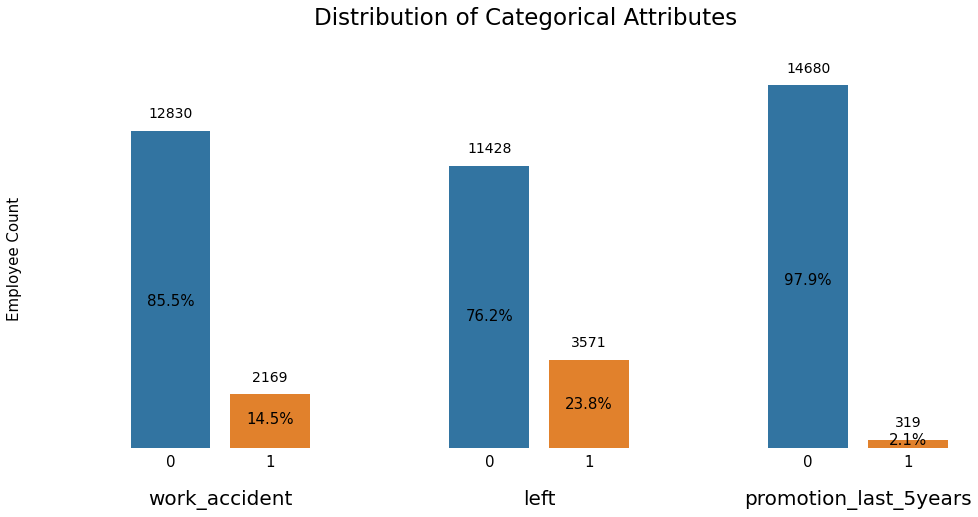

In [822]:
fig, axs = plt.subplots(1,3, figsize=(15,7), sharey=True, constrained_layout=True)
fig.suptitle('Distribution of Categorical Attributes', fontsize=23, y=1)
fig.supylabel('Employee Count', fontsize=15)
fig.subplots_adjust(wspace=0.6)

cols = ['work_accident', 'left', 'promotion_last_5years']

for i in range(len(cols)):
    sns.countplot(df[cols[i]], ax=axs[i])
    adjust_barplot(axs[i])

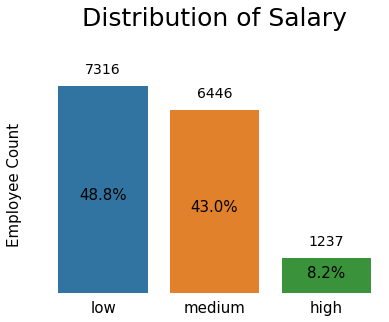

In [496]:
fig = sns.countplot(df['salary'], order=['low', 'medium', 'high'])
adjust_barplot(fig, title='Distribution of Salary')

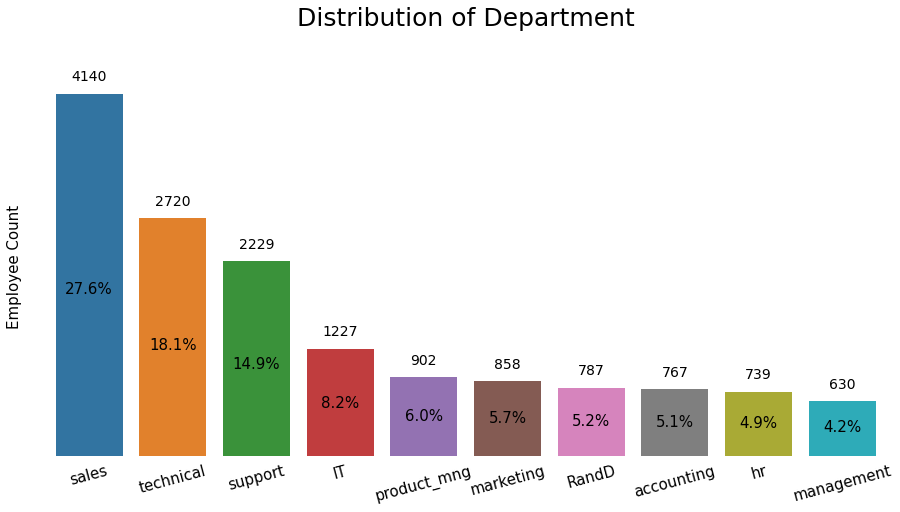

In [497]:
order = df['department'].value_counts().sort_values(ascending=False).index

plt.figure(figsize=(15,7))
fig = sns.countplot(df['department'], order=order)
adjust_barplot(fig, title='Distribution of Department', rotate=15)

## 2.2 Show Correlation between Attributes Using Heatmap

From the heatmap, it seems that there isn't any relatively strong correlation between attributes.

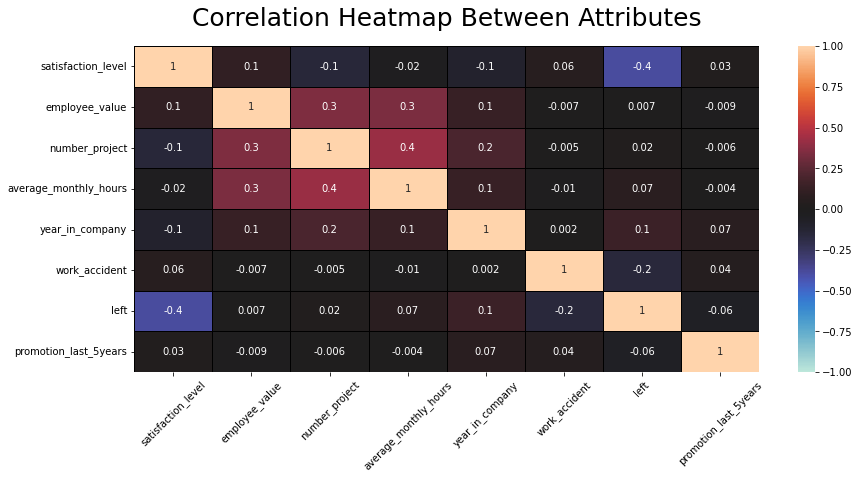

In [823]:
plt.figure(figsize=(14,6))
heatmap = sns.heatmap(df_uncat.corr(), annot=True, fmt='.1g', vmin=-1, vmax=1, center=0, 
                      linewidths=1, linecolor='Black')
heatmap.set_title('Correlation Heatmap Between Attributes', size=25, pad=20)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45)
plt.show()

## 2.3 Who Left the Company?

We plot the distribution of attributes for people who left the company (*`left = 1`*).

From the plot, we can see that for people who left the company:
- *`satisfaction_level`* : Lots of them had satisfaction level less than 0.5, and some of them had more than 0.7
- *`employee_value`* : They had been evaluated either about less than 0.6 or more than 0.8
- *`number_project`* : They worked on either 2 projects or at least 5 projects
- *`average_monthly_hours`* : They worked either less than 160 hours ore more than 220 hours monthly in average
- *`year_in_company`* : They stayed in company 3~5 years before leaving
- *`promotion_last_5years`* : Almost no one got promotion

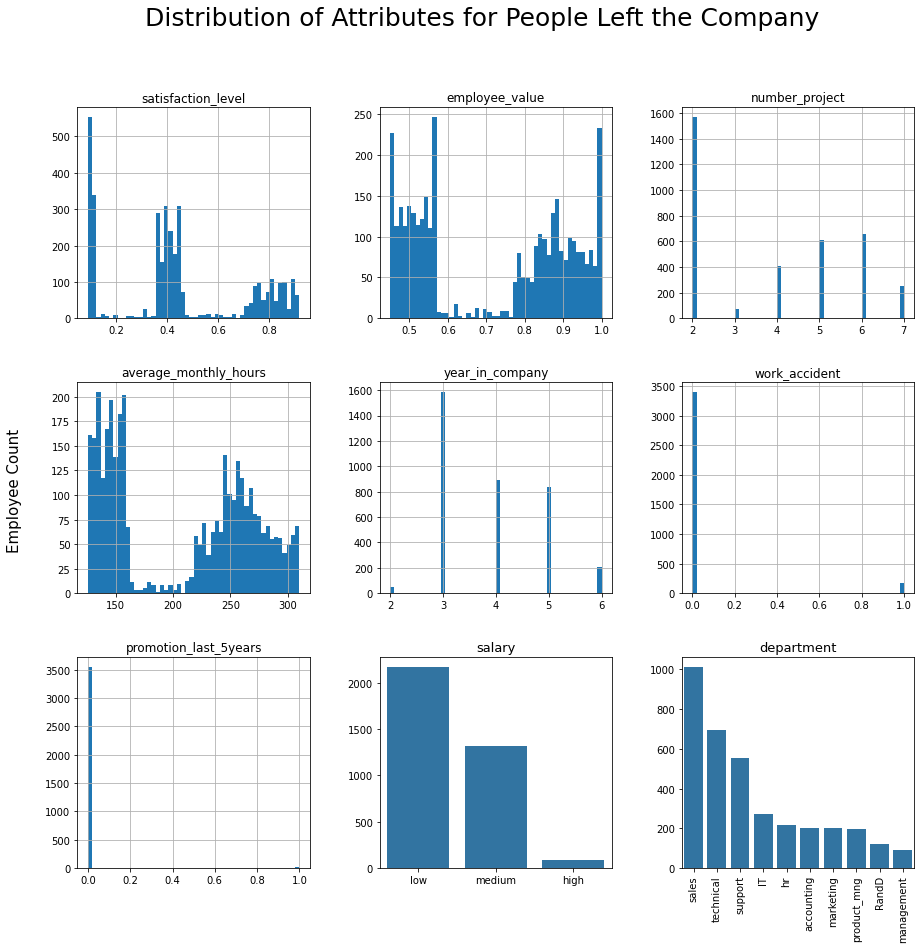

In [853]:
left_df = df[df['left'] == 1].loc[:, df.columns != 'left']

fig, axes = plt.subplots(figsize=(15,14))
# plot histogram of left_df
left_df.hist(bins=50, ax=fig)

def plot_countplot(ax, col):
    """
    Plot the countplot of a left_df column in descending order
    
    Parameters
    ----------
    ax : matplotlib.axes._subplots.AxesSubplot
        The matplotlib plot
    col : str
        The column name of left_df
    """
    order = left_df[col].value_counts().sort_values(ascending=False).index
    sns.countplot(left_df[col], order=order, color='#1f77b4')
    ax.xaxis.label.set_size(13)
    ax.xaxis.labelpad = 6
    ax.xaxis.set_label_position("top")
    ax.set_ylabel('')
    
    
# add a subplot of salary countplot
ax = fig.add_subplot(3,3,8)
plot_countplot(ax, 'salary')   

# add a subplot of department countplot
ax = fig.add_subplot(3,3,9)
plot_countplot(ax, 'department')
plt.xticks(rotation=90)


fig.suptitle('Distribution of Attributes for People Left the Company', size=25)
fig.supylabel('Employee Count', size=15, x=0.06)
fig.show()

## 2.4 Focus on high-value employees

From the last plot, we found that employees who left the company had been evaluated less than 0.6 or more than 0.8. The company probably don't want to keep those who scored under 0.6, but definitely want to keep those having high socres. 

We select those who scored at least 0.75 (*`employee_value >= 0.75`*) as high-value employees and analyze what they have in common.

After plotting the histogram, it is more clear that:
- They worked on at least 4 projects
- They worked more than 220 hours monthly in average
- They left the company at their forth or fifth year
- Almost no one got promotion

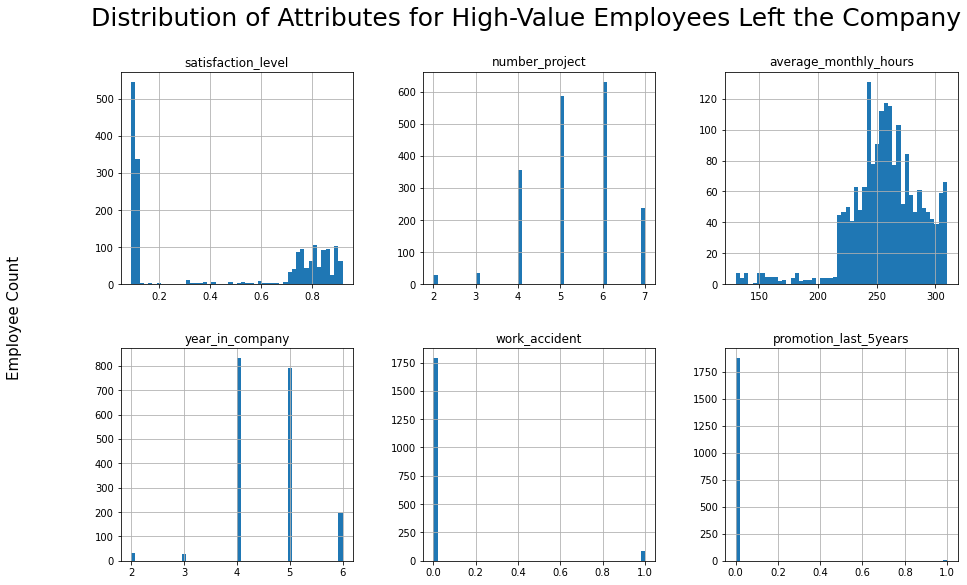

In [854]:
fig, axes = plt.subplots(figsize=(15,9))
good_left_df = left_df[left_df['employee_value'] >= 0.75].loc[:, left_df.columns != 'employee_value']
good_left_df.hist(bins=50, ax=fig, layout=(2,3))

fig.suptitle('Distribution of Attributes for High-Value Employees Left the Company', size=25)
fig.supylabel('Employee Count', size=15)

plt.show()

***

<h1 align='center'> 3. Build the Model </h1>

We will build and compare two different models :
- Logistic Regression
- Random Forest Classifier

First, we prepare the data for modeling:
- Split our data into a training and a test set
- Apply the min-max scaler to numeric attributes
- Apply one-hot encoding to categorical attributes (*`work_accident`*, *`promotion_last_5years`*, *`department`*, and *`salary`*)

Second, we train our model using training set and test it on the test set. We evaluate how good is the model by looking at its auc socre

Finally, we get features importances

## 3.1 Prepare Data for Modeling

In [743]:
X = df.drop(['left'], axis=1)
y = df['left']
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y)

numeric_col = X.columns[:5]
category_col = X.columns[5:]

full_pipeline = ColumnTransformer([
    ('numeric', MinMaxScaler(), numeric_col),
    ('category', OneHotEncoder(), category_col)
])

X_train_transform = full_pipeline.fit_transform(X_train)
X_test_transform = full_pipeline.transform(X_test)

## 3.2 Fit and Test the Model

We can see from the plot that (for roc curve, the closer to top-left corner, the better) Random Forest Classifier has a much better performance, scoring a 0.996 auc score.

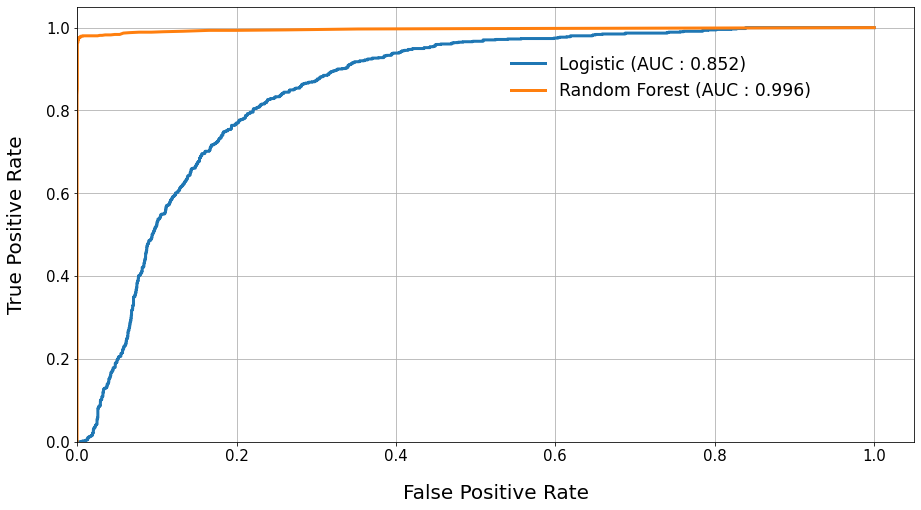

In [979]:
# fit the logistic regression model
logistic_reg = LogisticRegression().fit(X_train_transform, y_train)
y_proba_lr = logistic_reg.predict_proba(X_test_transform)[:, 1]
lr_score = roc_auc_score(y_test, y_proba_lr)

# fit the random forest classifier model
random_forest_clf = RandomForestClassifier().fit(X_train_transform, y_train)
y_proba_rf = random_forest_clf.predict_proba(X_test_transform)[:, 1]
rf_score = roc_auc_score(y_test, y_proba_rf)

# plot roc curves for two models
lr_fpr, lr_tpr, _ = roc_curve(y_test, y_proba_lr)
rf_fpr, rf_tpr, _ = roc_curve(y_test, y_proba_rf)
plt.figure(figsize=(15,8))
plt.plot(lr_fpr, lr_tpr, label=f'Logistic (AUC : {round(lr_score, 3)})', linewidth=3)
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC : {round(rf_score, 3)})', linewidth=3)
plt.xlabel('False Positive Rate', size=20, labelpad=20)
plt.ylabel('True Positive Rate', size=20, labelpad=20)
plt.tick_params(labelsize=15)
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.grid(True)
plt.legend(loc=(0.51, 0.77), fontsize='xx-large', frameon=False)
plt.show()

## 3.3 Find Feature Importances

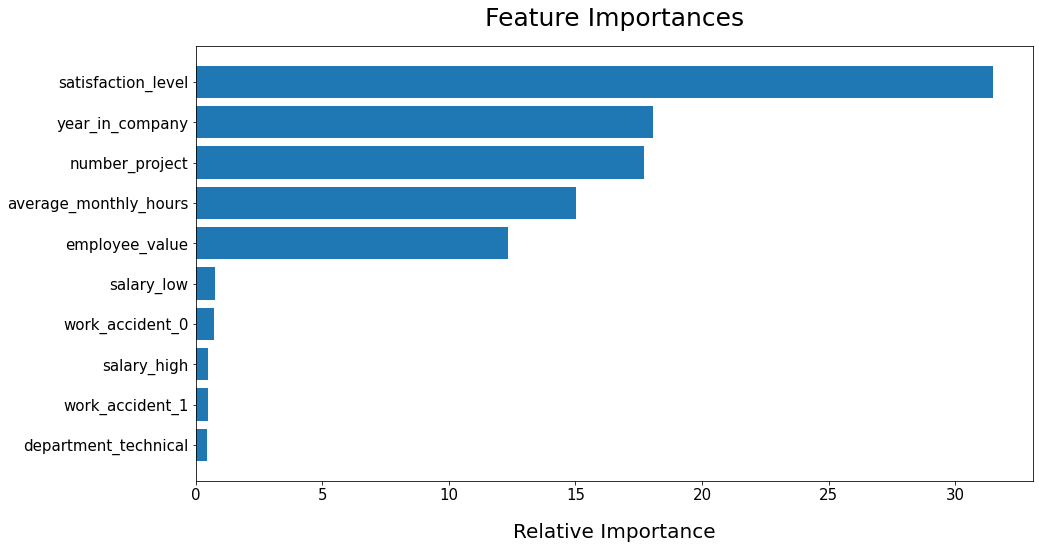

In [977]:
# get all feature names after one-hot encoding
category_encoder = full_pipeline.named_transformers_['category']
feature = list(numeric_col) + list(category_encoder.get_feature_names_out())

# get feature importances of random classifier model
importances = random_forest_clf.feature_importances_
index = np.argsort(importances)

plt.figure(figsize=(15,8))
plt.barh(range(len(index[-10:])), importances[index][-10:]*100, align='center')
plt.yticks(range(len(index[-10:])), [feature[i] for i in index[-10:]])
plt.title('Feature Importances', size=25, pad=20)
plt.xlabel('Relative Importance', size=20, labelpad=20)
plt.tick_params(labelsize=15)
plt.show()